# Frame identification

2 versions - By factor analysis and by using BERT embeddings and clustering (affinity propagation)
https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [558]:
import os

import pandas as pd

import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation

from nltk.tokenize import word_tokenize,sent_tokenize

from time import time
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

from collections import Counter

from time import time
import umap.umap_ as umap

# functions pickle_file and load_pickle merely help with storing pickled files in the event folders on drive
def pickle_file(file_name, file_to_dump):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path +  fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, 'wb') as fp:
        pickle.dump(file_to_dump, fp)

def load_pickle(file_name):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path + fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)


In [2]:
def read_event_df(event_name):
    data_url = fr"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_{event_name}_clean.csv"
    directory_path = os.getcwd() + "/../../../../" + data_url 
    event_df = pd.read_csv(directory_path, index_col=0)
    event_df.reset_index(drop=True, inplace=True)
    print(f'loaded {event_df.shape[0]} tweets!')
    return event_df

loaded 137462 tweets!


,source,text,lang,id,created_at,author_id,retweet_count,reply_count,like_count,quote_count,...,migrant,immigrant,asylum_seeker,other,date,text_coherent,retweet_count_sum,count,text_alphanum,text_stm
0,Hootsuite Inc.,PA Ambassador in Bosnia &amp; Herzegovina says...,en,1227019550912372737,2020-02-11 00:00:32+00:00,81136269,1,0,1,0,...,False,False,False,False,2020-02-11,PA Ambassador in Bosnia & Herzegovina says lif...,1,1,pa ambassador in bosnia herzegovina says life ...,ambassador bosnia herzegovina say life europe ...
1,u.fooo.ooo,[🔴 NEWS] Greece plans floating sea border wall...,en,1227019556167864321,2020-02-11 00:00:33+00:00,1052191553802854407,0,0,0,0,...,False,False,False,False,2020-02-11,[ NEWS] Greece plans floating sea border wall ...,0,1,news greece plans floating sea border wall to...,news greece plan floating border wall keep
2,Twitter Web Client,Latest Battle for Idlib Could Send Another Wav...,en,1227021374780313601,2020-02-11 00:07:47+00:00,18570470,0,0,1,1,...,False,False,False,False,2020-02-11,Latest Battle for Idlib Could Send Another Wav...,8,5,latest battle for idlib could send another wav...,latest battle idlib send another wave europe w...
3,Tweepsmap,UNHCR calls for decisive action to end alarmin...,en,1227021789525614594,2020-02-11 00:09:26+00:00,62632306,0,0,0,0,...,False,False,False,False,2020-02-11,UNHCR calls for decisive action to end alarmin...,9,3,unhcr calls for decisive action to end alarmin...,unhcr call decisive action alarming condition ...
4,Twitter for iPhone,"It is not your own feet sinking in the mud, bo...",en,1227022233484308481,2020-02-11 00:11:12+00:00,2729959018,9,1,29,1,...,False,False,False,False,2020-02-11,"It is not your own feet sinking in the mud, boy.",9,1,it is not your own feet sinking in the mud boy.,foot sinking


In [3]:
df_greece = read_event_df('greece')
df_channel = read_event_df('channel')
df_tigray = read_event_df('tigray')
df_rohingya = read_event_df('rohingya')

loaded 137462 tweets!
loaded 173758 tweets!
loaded 42853 tweets!
loaded 29432 tweets!


In [7]:
file_url = os.getcwd() + "/../../../../" + r"/Dropbox (CBS)/Master thesis data/"
event_url = file_url + r"Event Dataframes/"
event_url_clean = event_url + r"Clean/"

candidate_url = file_url + r"Candidate Data/"

In [102]:
tigray_url_clean = event_url_clean + r"df_tigray_clean.csv" # location of clean Tigray dataset
greece_url_clean = event_url_clean + r"df_greece_clean.csv" # location of clean Greece dataset
rohingya_url_clean = event_url_clean + r"df_rohingya_clean.csv" # location clean of Rohingya dataset
channel_url_clean = event_url_clean +r"df_channel_clean.csv" #Location of clean Channel dataset

In [123]:
tigray_url_fi = event_url_clean + r"df_tigray_fi.csv" # location of Tigray dataset for frame identification
greece_url_fi = event_url_clean + r"df_greece_fi.csv" # location of Greece dataset for frame identification
rohingya_url_fi = event_url_clean + r"df_rohingya_fi.csv" # location of Rohingya dataset for frame identification
channel_url_fi = event_url_clean +r"df_channel_fi.csv" #Location of Channel dataset for frame identification

In [8]:
tigray_candidate_url = candidate_url + r"tigray/tigray_ents"
greece_candidate_url = candidate_url + r"greece/greece_ents"
rohingya_candidate_url = candidate_url + r"rohingya/rohingya_ents"
channel_candidate_url = candidate_url + r"channel/channel_ents"

In [9]:
with open(greece_candidate_url,"rb") as input_file:
    ents = pickle.load(input_file)

In [10]:
def get_entity_list(url):
    with open(url,"rb") as input_file:
        ents = pickle.load(input_file)
        ents = ents[ents["freq"]>15]
        
    return list(ents["entity"])

In [11]:
tigray_ents = get_entity_list(tigray_candidate_url)
greece_ents = get_entity_list(greece_candidate_url)
rohingya_ents = get_entity_list(rohingya_candidate_url)
channel_ents = get_entity_list(channel_candidate_url)

In [107]:
ne_list = set(tigray_ents + greece_ents + rohingya_ents + channel_ents)

In [14]:
ne_list1 = str.split("abiy addis aegean afewerki afeworki afghan afghanistan africa african america amnesty ahmed american amhara andrew ankara antony arab asean asia assad aung bachelet balukhali bangladesh bangladeshi biden blinken boris borisjohnson borrell brexit brit britain british brussels bulgaria burma burmese calais canada channel china commission commissioner corona coronavirus council covid cox dover dublin edirne england english erdoan erdogan eritrea eritrean ethiopia ethiopian euro europe european evros farage filippo fontelles france french freya_cole garneau geneva german germany grandi greece greek guterres haavisto hamdayet harris hindu hitsats houthi houthis idlib idp india indian iran iraq isaias isayas isi israel italy jammu jazeera jerry johnson josep junta justin kachin kadra karen kayin kamala kent kenya kurd labour linda lindat_g lebanon lesbos lesvos libya london maikadra manipur marc merkel michelle mizoram moria muslim mutraw myanmar nation nations nationshumanrights nato nazi nigel november oromia oromo pakistan patel president priti putin reuters rohingya rohingyas russia russian samri secretary shimelba shire somalia spain state sudan sudanese syria syrian tegaru tigrai tigrayan tigrayans thai thailand tory tplf trudeau trump turk turkey turkish unhcr unicef union united unsc us yemen youtube"," ")
ne_list2 = str.split("able absolutely access according account accountable across action actually affected agency agree agreement alive allegation allow allowed allowing almost alone along already also always ambassador amid among another answer anti anymore anyone anything area arent around arrived article attempt attention away back based basic become believe best better black blame blocked born breaking bring brother build call called calling came cant case caught cause centre change claim claiming clear clearly close come coming comment commited commiting completely concern concerned condemn condition confirmed  continue continues could country course cover created credible crisis currently daily day deal dear decade decision demand department despite didnt difference different dire doesnt done dont east eastern easy either effort else endf enough especially ethnic even ever every everyone everything evidence evil exactly expect extremely face facility facing fact failed fake false federal feel find first found four forget free fuck fucking full genuine getting given giving great ground group happy imagine including issue instead isnt give going good half hand happen happened happening hard head heading held high horn hour however huge idea image immediate immediately independent information inside internal internally interview investigate investigation issue join journalist keep kind know known lack land landing largest last latest leader least left let letting level lie like likely little live living load local long longer look looking lost made mail major majority make making many massive matter maybe mean medium member middle might migration mind month morning mostly move much must name national near nearly need needed neighboring never news next nobody north northern nothing obviously office official one ongoing operation others paid part party pas past perhaps place plan please point post press prevails prime probably problem process programme provide public push putting question quite rather reach read real realise reality really reason received recent record remains remember report reported reporting resident response responsible rest result right said satellite say saying second seek seeking seem seems seen send sending sent series service several shame share shit show side simple simply since single site situation small someone something soon sorry sort south source speak special spread stand star start started statement street still stop stopped stopping story stupid sure surely system take taken taking talk talking tell term testimony thank thanks thats there theyre thing think though thought three time today told took torn towards town tried true truth trying turn tweet understand unless urgent urgently used using video vice view virus visit voice wait waiting want wanted watch water week welcome well west western withdraw within without whats whilst white whole wing wish wonder wont word world worse wrong would year yesterday young youre"," ")
ne_list = ne_list1 + ne_list2)
len(ne_list)

632

In [235]:
df_tigray = read_event_df(tigray_url_clean)
df_greece = read_event_df(greece_url_clean)
df_rohingya = read_event_df(rohingya_url_clean)
df_channel = read_event_df(channel_url_clean)

loaded 42843 tweets!
loaded 137418 tweets!
loaded 29423 tweets!
loaded 173615 tweets!


In [204]:
"""
from collections import Counter
from nltk.tokenize import word_tokenize

all_words = list()

for words in df_channel["text_stm"]:
    words_tok = word_tokenize(words)
    for word in words_tok:
        all_words.append(word)
"""

In [304]:
"""
counter = Counter(all_words)
counter.most_common() #counter_obj.most_common(n=10)

most_frequent_words = [pair[0] for pair in counter.most_common(int(len(counter)*0.025))]
"""

In [16]:
def get_most_frequent_words(df_col):
    
    all_words = list()
    
    for words in df_col:
        for word in words:
            all_words.append(word)
            
    counter = Counter(all_words)
    
    return [pair[0] for pair in counter.most_common(int(len(counter)*0.025))] #0.025

In [17]:
def tokenization(df_col):
    """
    Takes a list with strings and returns a list with tokens
    """
    print("Tokenizing tweets...\n")
    return df_col.apply(lambda x: word_tokenize(x))

def remove_unfrequent_words(df_col):
    print("Removing unfrequent words...\n")
    most_frequent_words = get_most_frequent_words(df_col)
    print(f"(Removing words that are not among {len(most_frequent_words)} most frequent ones.)\n")
    return df_col.apply(lambda x: [token for token in x if token in most_frequent_words])

def remove_named_entities(df_col):
    print("Removing named entities...\n")
    return df_col.apply(lambda x: [token for token in x if token not in ne_list])

def preprocessing(df_col, *steps):
    """
    Takes in a dataframe column with text and applies preprocessing steps given 
    in and returns a string.
    
    Input:
    - df (dataframe): The dataframe containing the text column.
    - steps (functions): Multiple functions for preprocessing can be given in.
    
    Output:
    - List with strings.
    """
    # copying over the column for preprocessing
    temp = df_col.copy()
    for func in steps:
        temp = func(temp)
    return temp.apply(lambda x: " ".join([token for token in x]))

In [507]:
#def remove_words(df_col, min_words):
#    
#    most_frequent_words = get_most_frequent_words(df_col, min_words)
#    print(f"(Removing words that are not among {len(most_frequent_words)} most frequent ones.)\n")
#    
#    words_to_keep = [word for word in most_frequent_words if word not in ne_list]
#    
#    df_col =  df_col.apply(lambda x: [token for token in x if token in words_to_keep])
#    return df_col.apply(lambda x: " ".join([token for token in x]))

In [508]:
#df_greece["tok"] = tokenization(df_greece["text_stm"])

#df_greece["text_frame_identification_001"] = remove_words(df_greece["tok"],0.001)
#df_greece["text_frame_identification_0025"] = remove_words(df_greece["tok"],0.025)
#df_greece["text_frame_identification_005"] = remove_words(df_greece["tok"],0.05)
#df_greece["text_frame_identification_01"] = remove_words(df_greece["tok"],0.1)

In [509]:
df_greece["text_frame_identification"] = preprocessing(df_greece["text_stm"],
                                                  tokenization,
                                                  remove_unfrequent_words,
                                                  remove_named_entities)

most_frequent_words = get_most_frequent_words(df_greece["text_stm"].apply(lambda x: word_tokenize(x)))
words_to_cluster_greece = [word for word in most_frequent_words if word not in ne_list]

Tokenizing tweets...

Removing unfrequent words...

(Removing words that are not among 1251 most frequent ones.)

Removing named entities...



In [116]:
df_tigray["text_frame_identification"] = preprocessing(df_tigray["text_stm"],
                                                  tokenization,
                                                  remove_unfrequent_words,
                                                  remove_named_entities)

most_frequent_words = get_most_frequent_words(df_tigray["text_stm"].apply(lambda x: word_tokenize(x)))
words_to_cluster_tigray = [word for word in most_frequent_words if word not in ne_list]

Tokenizing tweets...

Removing unfrequent words...

(Removing words that are not among 649 most frequent ones.)

Removing named entities...



In [117]:
df_channel["text_frame_identification"] = preprocessing(df_channel["text_stm"],
                                                  tokenization,
                                                  remove_unfrequent_words,
                                                  remove_named_entities)

most_frequent_words = get_most_frequent_words(df_channel["text_stm"].apply(lambda x: word_tokenize(x)))
words_to_cluster_channel = [word for word in most_frequent_words if word not in ne_list]

Tokenizing tweets...

Removing unfrequent words...

(Removing words that are not among 1245 most frequent ones.)

Removing named entities...



In [118]:
df_rohingya["text_frame_identification"] = preprocessing(df_rohingya["text_stm"],
                                                  tokenization,
                                                  remove_unfrequent_words,
                                                  remove_named_entities)

most_frequent_words = get_most_frequent_words(df_rohingya["text_stm"].apply(lambda x: word_tokenize(x)))
words_to_cluster_rohingya = [word for word in most_frequent_words if word not in ne_list]

Tokenizing tweets...

Removing unfrequent words...

(Removing words that are not among 486 most frequent ones.)

Removing named entities...



In [227]:
df_greece.columns

Index(['source', 'text', 'lang', 'id', 'created_at', 'author_id',
       'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'withheld.scope', 'hashtags', 'mentions', 'annotations', 'text_clean',
       'year', 'calendar_week', 'year_month', 'year_calendar_week', 'refugee',
       'migrant', 'immigrant', 'asylum_seeker', 'other', 'date',
       'text_coherent', 'retweet_count_sum', 'count', 'text_alphanum',
       'text_stm', 'text_frame_identification', 'tok',
       'text_frame_identification_0025', 'text_frame_identification_001',
       'text_frame_identification_005', 'text_frame_identification_01'],
      dtype='object')

In [198]:
df_greece_test = df_greece[["text","text_coherent","text_frame_identification","date",'text_frame_identification_0025', 'text_frame_identification_001',
       'text_frame_identification_005', 'text_frame_identification_01']]

In [200]:
#df_greece_test.to_csv('C:\\Users\\jawo19ad\\Documents\\GitHub\\refugee_project\\Code/../../../..//Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_greece_fi_test.csv')

In [121]:
df_greece_frame = df_greece[["text","text_coherent","text_frame_identification","date"]]
df_tigray_frame = df_tigray[["text","text_coherent","text_frame_identification","date"]]
df_rohingya_frame = df_rohingya[["text","text_coherent","text_frame_identification","date"]]
df_channel_frame = df_channel[["text","text_coherent","text_frame_identification","date"]]

#df_greece_frame.to_csv(greece_url_fi)
#df_tigray_frame.to_csv(tigray_url_fi)
#df_rohingya_frame.to_csv(rohingya_url_fi)
#df_channel_frame.to_csv(channel_url_fi)

## Create Embeddings

In [519]:
df_greece["text_frame_identification_len"] = df_greece["text_frame_identification"].apply(lambda x: len(x.split(" ")))

In [520]:
df_greece["text_frame_identification_len"].value_counts()

3     20356
1     19806
4     19368
2     19349
5     16773
6     13681
7     10174
8      7295
9      4707
10     2857
11     1624
12      807
13      387
14      138
15       62
16       17
17       12
18        3
19        1
20        1
Name: text_frame_identification_len, dtype: int64

In [537]:
df_greece_frame = df_greece[df_greece["text_frame_identification_len"] > 2]
df_greece_frame.shape

(98263, 32)

In [521]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [538]:
vectorizer = TfidfVectorizer()

In [539]:
embeddings = vectorizer.fit_transform(df_greece_frame["text_frame_identification"])

In [540]:
embeddings_dense = embeddings.toarray()

In [541]:
features = vectorizer.get_feature_names()

In [542]:
kmo_all,kmo_model=calculate_kmo(embeddings_dense)

C:\ProgramData\Anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [533]:
len(kmo_all)

778

In [534]:
sum(kmo_all > 0.5)

75

In [525]:
tf

array([False,  True,  True, False,  True, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
        True,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True, False, False,
       False,  True,  True, False, False,  True, False,  True,  True,
       False, False, False, False, False, False,  True, False, False,
        True, False, False,  True,  True,  True, False, False, False,
        True,  True, False,  True, False, False, False, False,  True,
        True, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
        True, False, False, False, False, False, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False,  True,

In [516]:
words_to_keep = [feature for feature,b in zip(features, tf) if b]

In [518]:
len(words_to_keep)

66

In [517]:
stopwords_greece = [word for word in vectorizer.get_feature_names() if word not in words_to_keep]

In [441]:
?TfidfVectorizer

In [485]:
vectorizer1 = TfidfVectorizer(stop_words=stopwords_greece,smooth_idf=True)
embeddings1 = vectorizer1.fit_transform(df_greece_frame["text_frame_identification"])

In [486]:
vectorizer1.get_feature_names()

['ally',
 'army',
 'attacking',
 'boat',
 'bomb',
 'bombing',
 'center',
 'child',
 'civil',
 'civilian',
 'clash',
 'coast',
 'coastguard',
 'community',
 'control',
 'create',
 'cross',
 'crossing',
 'defend',
 'dictator',
 'displaced',
 'family',
 'fence',
 'fire',
 'fled',
 'flee',
 'food',
 'force',
 'foreign',
 'guard',
 'health',
 'host',
 'hosting',
 'humanitarian',
 'humanity',
 'hundred',
 'illegally',
 'immigration',
 'innocent',
 'island',
 'jihadist',
 'kid',
 'killed',
 'military',
 'movement',
 'order',
 'police',
 'prevent',
 'protect',
 'protection',
 'regime',
 'return',
 'safe',
 'safety',
 'school',
 'security',
 'shelter',
 'shooting',
 'shot',
 'soldier',
 'tear',
 'territory',
 'terrorist',
 'thousand',
 'woman',
 'zone']

In [487]:
embeddings_dense1 = embeddings1.toarray()

In [488]:
# Bartlett’s test of sphericity (want to have p-value of 0)
chi_square_value, p_value=calculate_bartlett_sphericity(embeddings_dense1)
chi_square_value, p_value

(67181.24183884518, 0.0)

In [489]:
kmo_all,kmo_model=calculate_kmo(embeddings_dense1)

C:\ProgramData\Anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [490]:
kmo_model

0.4883275042305532

In [491]:
len(kmo_all)

66

In [492]:
sum(kmo_all > 0.5)

20

In [543]:
fa = FactorAnalyzer(rotation="varimax")
fa.fit(embeddings_dense)
print("Fit finished")
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

Fit finished


array([2.6133827 , 2.21037773, 2.12808771, 2.04872536, 2.01324092,
       1.90343566, 1.89038957, 1.82144031, 1.75288218, 1.74958462,
       1.7160321 , 1.70984263, 1.66775106, 1.65539361, 1.63624676,
       1.6196999 , 1.584113  , 1.57075678, 1.55080911, 1.52357934,
       1.49535572, 1.49120354, 1.48432804, 1.46049544, 1.44536733,
       1.43985184, 1.42082628, 1.41223356, 1.40794068, 1.39993617,
       1.39127757, 1.38471745, 1.37605247, 1.36986083, 1.36368748,
       1.35871824, 1.35384487, 1.35022442, 1.34645162, 1.33980598,
       1.33716343, 1.32927996, 1.32224255, 1.3201675 , 1.31703714,
       1.30960781, 1.304993  , 1.29997222, 1.29439724, 1.2923078 ,
       1.28884352, 1.28360973, 1.28074422, 1.27847388, 1.2750048 ,
       1.2683426 , 1.26370021, 1.26196918, 1.25695892, 1.25553796,
       1.25358248, 1.2483135 , 1.24606822, 1.24139883, 1.23827763,
       1.23678631, 1.23268562, 1.23223136, 1.22958554, 1.22643913,
       1.22377065, 1.22296032, 1.22158892, 1.21678385, 1.21584

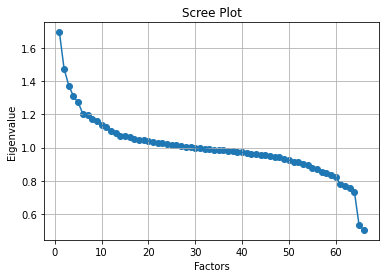

In [494]:
# Create scree plot using matplotlib
plt.scatter(range(1,embeddings_dense1.shape[1]+1),ev)
plt.plot(range(1,embeddings_dense1.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
?fa.fit

In [495]:
fa = FactorAnalyzer(6, rotation="varimax")
fa.fit(embeddings_dense1)

FactorAnalyzer(n_factors=6, rotation='varimax', rotation_kwargs={})

In [496]:
fa.loadings_

array([[-1.18090070e-02, -2.35786231e-03, -1.13885291e-02,
        -7.18883940e-02, -7.45804864e-03,  8.22315045e-03],
       [-3.04770220e-02, -1.17877831e-02, -5.63155471e-02,
        -3.63028750e-03, -2.25365244e-02,  3.28309722e-02],
       [ 2.19867315e-02, -1.60083135e-02, -2.12166517e-02,
         9.65154712e-03, -1.09406375e-02,  2.65093410e-02],
       [ 3.14493130e-01, -1.31574422e-02,  2.16547877e-02,
         7.90007249e-02, -2.24769774e-02, -1.50403080e-03],
       [-2.66709063e-02, -1.96561139e-02,  2.25698441e-02,
        -2.12021903e-03, -1.77978275e-02,  5.49844908e-02],
       [-1.24503740e-02, -6.52222418e-03,  3.66794122e-03,
        -1.04045365e-01, -5.94007252e-03,  4.74827825e-02],
       [-1.01441525e-02, -1.07609729e-03, -1.26556348e-02,
         8.35074611e-02, -2.78719922e-02, -2.52565694e-01],
       [-4.44914045e-03, -6.19417741e-02,  5.45025013e-01,
         1.67582957e-01, -4.39866733e-02,  1.13214310e-01],
       [-8.74556545e-03, -8.48155919e-03,  1.026

In [498]:
factor_dict =dict()
for word,factor in zip(words_to_cluster,fa.loadings_):
    factor_dict[word] = factor
    
factor_df = pd.DataFrame.from_dict(factor_dict)
factor_df

,million,right,crisis,stop,help,camp,child,year,back,illegal,...,migration,policy,invasion,another,give,last,work,today,fire,free
0,-0.011809,-0.030477,0.021987,0.314493,-0.026671,-0.012450,-0.010144,-0.004449,-0.008746,-0.018948,...,-0.012717,0.045992,0.037778,-0.017317,-0.071228,-0.006588,-0.020206,-0.060769,-0.017748,-0.038564
1,-0.002358,-0.011788,-0.016008,-0.013157,-0.019656,-0.006522,-0.001076,-0.061942,-0.008482,-0.000697,...,0.001999,-0.018453,-0.015605,-0.017398,-0.048208,0.002507,-0.013944,0.991078,-0.038544,-0.007961
2,-0.011389,-0.056316,-0.021217,0.021655,0.022570,0.003668,-0.012656,0.545025,0.010268,0.005781,...,0.060644,-0.027562,-0.052311,-0.059997,-0.123713,-0.032844,-0.019099,0.017303,0.352648,-0.029774
3,-0.071888,-0.003630,0.009652,0.079001,-0.002120,-0.104045,0.083507,0.167583,-0.055881,-0.162454,...,-0.033869,0.016482,0.038174,-0.075964,0.266565,-0.013477,-0.087898,0.091564,0.087245,-0.002055
4,-0.007458,-0.022537,-0.010941,-0.022477,-0.017798,-0.005940,-0.027872,-0.043987,-0.007186,0.006609,...,-0.002674,-0.026116,-0.036081,-0.047407,-0.063016,0.015515,0.006207,-0.030184,-0.025837,0.509421
5,0.008223,0.032831,0.026509,-0.001504,0.054984,0.047483,-0.252566,0.113214,-0.017546,0.098905,...,-0.003418,0.044922,0.079311,0.110882,0.155130,-0.053041,-0.000422,0.022026,0.072091,0.037960


In [504]:
factor_df_transposed = factor_df.T 
factor_df_transposed[factor_df_transposed[0]>0.1]

,0,1,2,3,4,5
stop,0.314493,-0.013157,0.021655,0.079001,-0.022477,-0.001504
human,0.769323,0.010709,-0.038478,0.111680,0.009912,0.069441
life,0.560959,-0.001041,-0.081945,0.108192,-0.019040,0.119905


In [501]:
embeddings1.shape

(62252, 66)

In [ ]:
vector_dict =dict()
for word,vector in zip(words_to_cluster,embeddings):
    vector_dict[word] = vector
    
vector_df = pd.DataFrame.from_dict(vector_dict)

In [450]:
df_greece["text_frame_identification"]

0                                               life
1                                             border
2                                               wave
3                                     island hosting
4                                                   
                             ...                    
137457                                              
137458                     army border mass invasion
137459                                poor home work
137460           attack border invasion attack force
137461    crime attack fighting invader border guard
Name: text_frame_identification, Length: 137418, dtype: object

In [213]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def aggregate_frames(framed_entities):
    frame_copy = framed_entities.copy()
    aggr_frames = frame_copy.groupby(['entity'],as_index=True).count()    
    aggr_frames.drop(['framing_word','date'],axis=1,inplace=True)
    aggr_frames = aggr_frames.T
    aggr_frames =  aggr_frames.groupby(aggr_frames.index)[aggr_frames.columns].first()

    aggr_frames = aggr_frames / aggr_frames.sum()

    return aggr_frames



def frame_heatmap(aggr_frames):
    aggr_frames = aggr_frames.T

    ax = sns.heatmap(aggr_frames,cmap='Blues')
    #ax.set_xlabel('X LABEL')    
    loc, labels = plt.xticks()

    ax.set_xticklabels(labels, rotation=90)
    ax.xaxis.set_ticks_position('top') 

In [231]:
frame_properties = load_pickle('all_final_frames')

In [232]:
frame_properties['vulnerability']

['pray',
 'fault',
 'persecution',
 'praying',
 'homeless',
 'affected',
 'love',
 'hate',
 'health',
 'care',
 'missing',
 'desperate',
 'famine',
 'hospital',
 'poor',
 'hunger',
 'devastating',
 'starvation',
 'broke',
 'injured',
 'victim',
 'starving',
 'hope',
 'suffering']

In [228]:
framed_entities = load_pickle('greece_framed_entities')

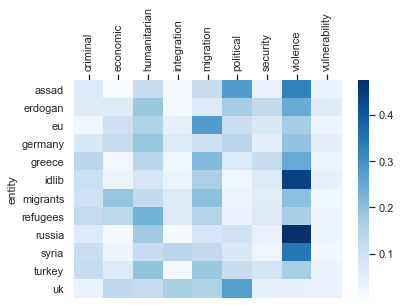

In [229]:
frame_heatmap(aggregate_frames(framed_entities))

In [365]:
frent = load_pickle('greece_framed_entities')
frent

,entity,framing_word,date,humanitarian,economic,security,political,criminal,integration,vulnerability,migration,violence
0,eu,europe,2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,eu,life,2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,refugees,refugees,2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,refugees,dream,2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,greece,greece,2020-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
807372,germany,germany,2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807373,germany,video,2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807374,migrants,migrant,2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807375,migrants,crisis,2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train BERT

In [125]:
from collections import Counter
def get_most_frequent_words(df_col):
    
    def clean_nes(tweet_words):
        return " ".join([word for word in tweet_words.split() if word not in ne_list])
    #tokenized_cols = df_col.apply(lambda x: word_tokenize(x) if len(x)>0 else x)
    df_col = df_col[~df_col.isnull()] 
    #df_col = df_col.apply(lambda x: print(x.split()) )
    #df_col = df_col.apply(clean_nes)
    #print(df_col)
    counter = Counter(" ".join(df_col).split())
    #print(counter.most_common(200))
    words = [pair[0] for pair in counter.most_common(250)]

    words = [word for word in words if word not in removed_words]

    return words # list(set(words).difference(set(removed_words)))

print('aegean' not in removed_words)
def embed_words(words):
    from time import time
    from sentence_transformers import SentenceTransformer
    #sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

    #bert_corpus = list(words['entity'])

    print(f'there are {len(words)} entities to be encoded')
    t0 = time()
    word_embeddings = sbert_model.encode(words)
    print(f'Training embeddings took {time()-t0} seconds')
    return word_embeddings

True


In [44]:
ne_list1 = str.split("abiy addis aegean afewerki afeworki afghan afghanistan africa african ahval aleppo  america \
                     amnesty ahmed american amhara andrew ankara antony arab arabia asean asia assad athens aung \
                     austria axum bangladesh bangladeshi biden blinken boris borisjohnson borrell brexit brit britain \
                     british brussels bulgaria bulgarian burma burmese calais canada \
                     channel bengal china chios commission commissioner corona coronavirus council coup covid cox \
                     cyprus delhi dover dublin edirne egypt england english erdoan erdogan erdogans  eritrea eritrean \
                     ethiopia ethiopian euro europe european evros farage filippo finland fontelles france french \
                     freya_cole frontex garneau geneva german germany grandi greece greek guterres haavisto hamdayet \
                     harris hindu hitsats hlaing houthi houthis hungary idlib idp india indian iran iranian iraq \
                     iraqi ireland irish isaias isayas isi israel istanbul italy italian jammu japan jazeera jerry \
                     johnson jordan josep junta justin kachin kadra karen kayin kamala kashmir kastanies kenneth kent \
                     kenya kurd kurdish labour leyen linda lindat_g lebanon lesbos lesvos libya london macron mahlakon \
                     maikadra malaysia manipur marc matthew mediterranean merkel michelle mitsotakis mizoram modi moria \
                     muslim mutraw myanmar nato nazi nigel november obama oromia oromo pakistan pakistani palestine \
                     palestinian patel pazarkule poland president priti putin qaeda rakhine recep reuters rohingya \
                     rohingyas roth rterdogan russia russian samri saudi scotland secretary shimelba shire somalia \
                     soros spain state sudan sudanese sweden syria syrian tayyip tegaru tigrai tigray tigrayan \
                     tigrayans thai thailand tory tostevin tplf trudeau trump turk turkey turkish twitter unhcr unicef \
                     union unsc us yangon yemen york youtube"," ")
ne_list2 = str.split("attempt  blocked born bring brother build call called calling came cant case caught cause \
                     centre change christian claim claiming clear clearly close come coming comment commited \
                     commiting committed committing completely condition confirmed  continue continues could \
                     country course cover created credible  currently daily day deal dear decade decision demand \
                     department despite didnt difference different dire displaced doesnt done dont dy east eastern \
                     easy either effort else endf enough especially ethnic even ever every everyone everything \
                      evil exactly expect extremely face facility facing fact failed fake false federal \
                     feel find first found four forget free fuck fucking full genuine getting given giving great \
                     ground group happy imagine including issue instead isnt give going good half hand happen \
                     happened happening happeningln hard head heading held high horn hour however huge idea image \
                     immediate immediately independent information inside internal internally international interview  \
                     investigation islam islamic issue join journalist keep kind know known lack land landing largest \
                     last latest le  least left let letting level lie like likely little live living load local \
                     long longer look looking lost made mail major majority make making many  matter maybe \
                     mean meanwhile medium member middle might migration mind month morning mostly move much must \
                     name national near nearly need needed neighboring never news next nobody north northern nothing \
                     obviously office official one ongoing operation others paid part party pas past people perhaps \
                     person place plan please point post press prevails prime probably  process programme \
                     provide  push putting question quite rather reach read real realise reality really reason \
                     received recent record reqion remains remember report reported reporting resident response \
                      rest result right said satellite say saying second seek seeker seeking seem seems \
                     seen send sending sent series service several shame share shit show side simple simply since \
                     single site situation small someone something soon sorry sort south source speak  spread \
                     stand star start started statement street still stop stopped stopping story  sure surely \
                      take taken taking talk talking tell term testimony thank thanks thats there theyre thing \
                     think though thought three time today told took  towards town tried true truth trying turn \
                     tweet understand unless  used using video vice view virus visit voice wait waiting \
                     want wanted watch water week  well west western  within without whats whilst white \
                     whole wing wish wonder wont word world  wrong would year yesterday young youre"," ")
part_of_ne = str.split(" agency asylum bazar seeker united nation nations nationshumanrights ")
ambiguous = str.split(" access according account action  agreement  allowed allowing arriving back become \
                    believe best better black breaking came closed caused come coming cross deal do done enter entering \
                    event fear find full get getting give given go going gone good got hate hope keep large last leave leaving left love \
                      made make making march matter massive mean medium need open opened part point return \
                      returned right said say \
                      saying seek send show special start stop sure surely take taken taking tear torn tell thing think \
                      time trying turn urgent urgently withdraw")
temp_num = str.split(" always april  daily first  mass  monday never night number  today \
                     week year ")
non_pos = str.split("  able absolutely across actually almost along alone already also amid among another anti anymore anyone \
                    anything arent around away based cant dont enough every le majority maybe \
                    many much nothing \
                    rather really something still thats theyre without")

non_framing = str.split('agree allow ambassador answer area arrived article basic beach blame boat border camp \
                        center choose\
                        coast country city convention crisis dinghy create culture district food force \
                        forest hold hotel history idiot illegally immigration internet island language leader \
                        leaf life migration minister navy news order photo population power problem public \
                        pushing rapporteur region responsible responsibility river route royal save ship shore solution \
                        status stay stupid system township village water white worse zone')
tigray = str.split('organization mission campaign targeted corridor missing')
ne_list = part_of_ne + ambiguous + temp_num + non_pos + ne_list2  + non_framing + tigray#+ ne_checkpoint

In [465]:
ne_list = 'abiy africa ahmed amhara amnesty andrew antony asean assad axum bangladesh bangladeshi biden blinken boris borisjohnson brexit britain british bulgaria burma burmese calais channel china commission coronavirus council coup covid cox dover dublin england english erdogan eritrea eritrean ethiopia ethiopian europe european evros farage filippo france french freya_cole germany grandi greece greek guterres harris hindu hitsats hlaing idlib idp india indian iran isaias jammu johnson junta kachin kadra kamala karen kent labour lesbos maikadra manipur mizoram muslim myanmar nato nigel pakistan patel president priti putin rohingya rohingyas russia russian secretary shimelba shire state sudan sudanese syria syrian thai thailand tigrai tigray tigrayan tigrayans tory tplf trudeau turk turkey turkish unhcr union unsc yangon yemen'.split(" ")

non_framing = 'minority community villager access according across action actually agency allow already always another anyone april area around arriving asylum away back bazar believe better blame border call called came came campaign cant cant case centre change city claim close closed coast come come coming coming committed continue country country crisis cross daily daily day deal deal dear displaced district done done dont dont east enough enough enter ethnic every every face fact fake find find first first force free full full genuine getting getting give give given given going going good good great group happening happeningln hate head hope huge illegally  including internally international internet island issue issue keep keep land last last le le leader least leave leaving left left life live living local long longer look lost made made majority majority make make making making many many march mass massive maybe maybe mean mean medium medium member middle missing mission month morning move much much nation navy need need never never news news night northern nothing nothing number office official ongoing open opened order part part people photo place plan please point point population problem provide public push rapporteur rather rather reach read real really really reason region report reported return right right said said save say say saying saying seek seek seeker seeker send send sending sent service shame shore show show side situation small something something source south special stand start stay still still stop stop story sure sure system taking taking talk targeted tear tell tell thank thats thats theyre theyre thing thing think think time time today today told towards township truth trying trying turn turn united urgent urgently used using vice video village virus voice wait want watch water water week week west western whats white white without without world wrong year year yesterday zone'.split(" ")

search_terms = str.split("refugee refugees migrant migrants immigrant immigrants asylum seeker seekers displaced stateless people person persons"," ")

added_today = str.split("fire conflict foreign condition camp boat dinghy wave flood citizen"," ")

channel_words = str.split("feel agreement agree desperate route anti dangerous little someone young seeking word party beach next anything ever instead youre become allowed convention street apply matter taken thought understand true accept might", " ")

tigray_words = str.split("axum organization unity independent lie happened hand based high others tigray evidence town witness investigation", " ")

rohingya_words = str.split("blaze leaf forest ground staff coup yangon supreme federal modi broke affected blackout caused held event pray praying needed strike hlaing near several within large mahlakon largest"," ")

removed_words = list(set(ne_list1 + non_framing + search_terms + added_today + channel_words + tigray_words + rohingya_words))

len(removed_words)

507

In [19]:
df_greece = read_event_df('greece')
df_channel = read_event_df('channel')
df_tigray = read_event_df('tigray')
df_rohingya = read_event_df('rohingya')

loaded 137462 tweets!
loaded 173758 tweets!
loaded 42853 tweets!
loaded 29432 tweets!


In [466]:
most_frequent_words_greece = get_most_frequent_words(df_greece["text_stm"])
most_frequent_words_channel = get_most_frequent_words(df_channel["text_stm"])
most_frequent_words_tigray = get_most_frequent_words(df_tigray["text_stm"])
most_frequent_words_rohingya = get_most_frequent_words(df_rohingya["text_stm"])
most_frequent_words = list(set(most_frequent_words_greece+most_frequent_words_channel+most_frequent_words_tigray+most_frequent_words_rohingya))

In [467]:
"""
event_df = read_event_df('channel')
most_frequent_words2 = get_most_frequent_words(event_df["text_stm"])
event_df = read_event_df('tigray')
most_frequent_words3 = get_most_frequent_words(event_df["text_stm"])
event_df = read_event_df('rohingya')
most_frequent_words4 = get_most_frequent_words(event_df["text_stm"])

#words_to_cluster = list(set(most_frequent_words1 + most_frequent_words2 + most_frequent_words3 + most_frequent_words4))
event_df = read_event_df('greece')
most_frequent_words1 = get_most_frequent_words(event_df["text_stm"])

most_frequent_words = list(set(most_frequent_words1+most_frequent_words2+most_frequent_words3+most_frequent_words4))

#len(set(most_frequent_words).difference(set(removed_words)))
"""

'\nevent_df = read_event_df(\'channel\')\nmost_frequent_words2 = get_most_frequent_words(event_df["text_stm"])\nevent_df = read_event_df(\'tigray\')\nmost_frequent_words3 = get_most_frequent_words(event_df["text_stm"])\nevent_df = read_event_df(\'rohingya\')\nmost_frequent_words4 = get_most_frequent_words(event_df["text_stm"])\n\n#words_to_cluster = list(set(most_frequent_words1 + most_frequent_words2 + most_frequent_words3 + most_frequent_words4))\nevent_df = read_event_df(\'greece\')\nmost_frequent_words1 = get_most_frequent_words(event_df["text_stm"])\n\nmost_frequent_words = list(set(most_frequent_words1+most_frequent_words2+most_frequent_words3+most_frequent_words4))\n\n#len(set(most_frequent_words).difference(set(removed_words)))\n'

In [468]:
"""
#event_df = read_event_df('channel')
most_frequent_words = get_most_frequent_words(event_df["text_stm"])
len(most_frequent_words)

new_ne_list = [word for word in ne_list if word in most_frequent_words]
#    list(set(ne_list).difference(set(words_to_cluster)))
" ".join(sorted(new_ne_list))

"""

'\n#event_df = read_event_df(\'channel\')\nmost_frequent_words = get_most_frequent_words(event_df["text_stm"])\nlen(most_frequent_words)\n\nnew_ne_list = [word for word in ne_list if word in most_frequent_words]\n#    list(set(ne_list).difference(set(words_to_cluster)))\n" ".join(sorted(new_ne_list))\n\n'

In [555]:
def create_frames(embedding, preference, most_frequent_words):
    cluster = AffinityPropagation(preference = preference,  random_state=42).fit(embedding)
    cluster_labels = cluster.labels_
    
    labeled_tweet = pd.DataFrame({'word': most_frequent_words,'label':cluster_labels})
    
    # Create documents per label
    docs_per_class = labeled_tweet.groupby(['label'], as_index=False).agg({'word': ' '.join})

    words_per_class = dict()
    for label,word in zip(docs_per_class['label'],docs_per_class['word']):
        words_per_class[label] = word.split(' ')
    return (pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in words_per_class.items() ])).fillna('.').head(50),words_per_class)
    

### Greece

In [470]:
len(most_frequent_words_greece)

65

In [471]:
greece_embeddings = embed_words(most_frequent_words_greece)

there are 65 entities to be encoded
Training embeddings took 0.5062229633331299 seconds


In [479]:
start = time()
reduced_embedding_greece = umap.UMAP(random_state=42,
                                     n_components=3,
                                     min_dist=0.1,
                                     n_neighbors = 5).fit_transform(greece_embeddings)
print(f'Duration: {time() - start} seconds')

Duration: 1.668034315109253 seconds


In [575]:
greece_frame_df, greece_frame_dict = create_frames(reduced_embedding_greece,-4,most_frequent_words_greece)

In [ ]:
"""
humanitarian
reception
migration
security
violence
political
economic
military
criminal
"""

In [577]:
pickle_file("greece_frame_devices",greece_frame_dict)

In [ ]:
"""
securitisation
criminality
threat/violence
political
economic
humanitarian
militarisation
"""

### Channel

In [483]:
len(most_frequent_words_channel)

51

In [484]:
channel_embeddings = embed_words(most_frequent_words_channel)

there are 51 entities to be encoded
Training embeddings took 0.4698755741119385 seconds


In [498]:
start = time()
reduced_embedding_channel = umap.UMAP(random_state=42,
                                     n_components=3,
                                     min_dist=0.1,
                                     n_neighbors = 10).fit_transform(channel_embeddings)
print(f'Duration: {time() - start} seconds')

Duration: 1.7096350193023682 seconds


In [501]:
create_frames(reduced_embedding_channel,-2,most_frequent_words_channel)

,0,1,2,3,4,5,6
0,government,home,economic,illegal,safe,crossing,child
1,legal,hotel,money,racist,help,immigration,work
2,voted,house,million,criminal,benefit,fleeing,family
3,policy,welcome,thousand,police,support,invasion,human
4,rule,housing,poor,illegals,control,migration,woman
5,govt,homeless,paying,crime,care,entering,working
6,vote,.,cost,.,death,arrive,job
7,law,.,paid,.,risk,.,.
8,taxpayer,.,.,.,.,.,.


In [560]:
channel_frame_df, channel_frame_dict = create_frames(reduced_embedding_channel,-2,most_frequent_words_channel)

In [562]:
pickle_file("channel_frame_devices",channel_frame_dict)

In [ ]:
"""
political
accomodation
economisation
criminality
support
migration
integration
"""

### Tigray

In [504]:
len(most_frequent_words_tigray)

76

In [505]:
tigray_embeddings = embed_words(most_frequent_words_tigray)

there are 76 entities to be encoded
Training embeddings took 0.8544445037841797 seconds


In [524]:
start = time()
reduced_embedding_tigray = umap.UMAP(random_state=42,
                                     n_components=3,
                                     min_dist=0.1,
                                     n_neighbors = 5).fit_transform(tigray_embeddings)
print(f'Duration: {time() - start} seconds')

Duration: 1.4146029949188232 seconds


In [530]:
create_frames(reduced_embedding_tigray,-10,most_frequent_words_tigray)

,0,1,2,3,4,5,6,7
0,million,fled,food,civilian,crime,genocide,innocent,human
1,thousand,fleeing,starvation,militia,rape,killed,protect,humanitarian
2,hundred,flee,starving,government,violence,killing,care,woman
3,.,.,famine,troop,raped,massacre,peace,help
4,.,.,hunger,soldier,terrorist,destroyed,safe,child
5,.,.,.,army,criminal,looting,safety,home
6,.,.,.,military,forced,death,health,support
7,.,.,.,govt,atrocity,massacred,protection,family
8,.,.,.,dictator,attack,looted,security,assistance
9,.,.,.,.,victim,destruction,.,work


In [563]:
tigray_frame_df, tigray_frame_dict = create_frames(reduced_embedding_tigray,-10,most_frequent_words_tigray)

In [565]:
pickle_file("tigray_frame_devices",tigray_frame_dict)

In [ ]:
"""
misc
misc
vulnerabilty
political/military
criminality
violence
support/protection (maybe even outreach)
humanitarian
"""

### Rohingya

In [531]:
len(most_frequent_words_rohingya)

79

In [532]:
rohingya_embeddings = embed_words(most_frequent_words_rohingya)

there are 79 entities to be encoded
Training embeddings took 0.8724038600921631 seconds


In [545]:
start = time()
reduced_embedding_rohingya = umap.UMAP(random_state=42,
                                     n_components=3,
                                     min_dist=0.1,
                                     n_neighbors = 10).fit_transform(rohingya_embeddings)
print(f'Duration: {time() - start} seconds')

Duration: 1.4543967247009277 seconds


In [552]:
create_frames(reduced_embedding_rohingya,-4,most_frequent_words_rohingya)

,0,1,2,3,4,5,6,7,8
0,military,child,killed,government,fleeing,terrorist,thousand,shelter,help
1,army,human,killing,illegal,fled,airstrikes,hundred,food,humanitarian
2,civilian,home,dead,authority,flee,attack,million,safe,support
3,soldier,family,massacre,democracy,deportation,police,.,safety,supply
4,brigade,house,genocide,forced,.,violence,.,injured,donation
5,fighter,worker,death,govt,.,crackdown,.,suppression,supporting
6,armed,woman,devastating,court,.,crime,.,security,emergency
7,jet,humanity,destroyed,detained,.,attacked,.,protect,assistance
8,.,homeless,burnt,forcing,.,besieging,.,health,donate
9,.,work,died,envoy,.,bombing,.,innocent,aid


In [566]:
rohingya_frame_df, rohingya_frame_dict = create_frames(reduced_embedding_rohingya,-4,most_frequent_words_rohingya)

In [568]:
pickle_file("rohingya_frame_devices",rohingya_frame_dict)

In [ ]:
"""
military
protection
violence
political
misc
violence (merge with other)
misc
protection (merge with other)
humanitarian
"""

In [190]:
words_to_cluster = most_frequent_words.copy() 
#words_to_cluster.remove('boat')

In [191]:
event_embeddings = embed_words(words_to_cluster)

there are 47 entities to be encoded
Training embeddings took 0.5869946479797363 seconds


In [198]:
from time import time
import umap.umap_ as umap
start = time()
reduced_embedding = umap.UMAP(random_state=42,
                              n_components=3,
                             min_dist=0.1,
                              n_neighbors = 15).fit_transform(event_embeddings)
print(f'Duration: {time() - start} seconds')

Duration: 1.2751195430755615 seconds


In [207]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(preference = -5,  random_state=42).fit(reduced_embedding)
cluster_labels = clustering.labels_
cluster_centers = clustering.cluster_centers_
center_indices = clustering.cluster_centers_indices_
#cluster_labels

In [146]:
from hdbscan import HDBSCAN
#from sklearn.cluster import DBSCAN

cluster_labels = HDBSCAN(min_cluster_size=7,min_samples=1, cluster_selection_epsilon = 0.0005, gen_min_span_tree=True).fit_predict(reduced_embedding)

In [2143]:
from sklearn.cluster import KMeans
#from sklearn.cluster import DBSCAN

cluster_labels = KMeans(n_clusters=8).fit_predict(reduced_embedding)

<AxesSubplot:>

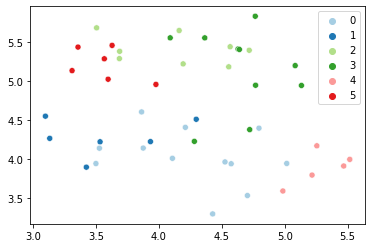

In [208]:
import seaborn

seaborn.scatterplot(x = reduced_embedding[:, 0],
                y = reduced_embedding[:, 1],
                hue = cluster_labels, palette ="Paired")

In [172]:
import plotly.express as px

fig = px.scatter_3d(x=reduced_embedding[:, 0], 
                    y=reduced_embedding[:, 1], 
                    z=reduced_embedding[:, 2],
                    color=cluster_labels,
                    opacity = 0.7,
                    size_max=1)#,labels =True)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [498]:
#clustering the clusters

center_clustering = AffinityPropagation(preference = 10, random_state=42).fit(cluster_centers)
center_cluster_labels = center_clustering.labels_

In [ ]:
import seaborn

seaborn.scatterplot(x = cluster_centers[:, 0],
                y = cluster_centers[:, 1],
                hue = center_cluster_labels, palette ="Paired")

In [ ]:
clust_label_dict = {label: str(center) for label, center in zip(clustering.predict(cluster_centers), cluster_centers)}
#clust_label_dict
clusters = {str(center):label for label, center in zip(center_clustering.predict(cluster_centers),cluster_centers)}

In [203]:
labeled_tweets = pd.DataFrame({'word': words_to_cluster,'label':cluster_labels})
#labeled_tweets['new_label'] = labeled_tweets.label.apply(lambda x: clusters[clust_label_dict[x]])
#labeled_tweets['label'] = labeled_tweets['label'].apply(lambda x: clusters[x])
# Create documents per label
docs_per_class = labeled_tweets.groupby(['label'], as_index=False).agg({'word': ' '.join})

words_per_class = dict()
for label,word in zip(docs_per_class['label'],docs_per_class['word']):
    words_per_class[label] = word.split(' ')
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in words_per_class.items() ])).fillna('.').head(50)

,0,1,2,3,4
0,government,illegal,safe,boat,economic
1,legal,crossing,help,home,money
2,citizen,racist,work,hotel,million
3,voted,immigration,benefit,child,thousand
4,policy,fleeing,support,family,death
5,rule,criminal,control,dinghy,desperate
6,police,invasion,care,house,poor
7,govt,migration,risk,welcome,.
8,vote,.,apply,human,.
9,.,.,.,camp,.


In [ ]:
minority community villager

In [437]:
final_frames = load_pickle('tigray_framed_entities')
#print(final_frames)

          entity framing_word        date  humanitarian  economic  security  \
0       ethiopia     ethiopia  2021-01-15           NaN       NaN       NaN   
1       ethiopia         ocha  2021-01-15           NaN       NaN       NaN   
2             un           un  2021-01-15           NaN       NaN       NaN   
3             un       agency  2021-01-15           NaN       NaN       NaN   
4             un         ocha  2021-01-15           NaN       NaN       NaN   
...          ...          ...         ...           ...       ...       ...   
256820     sudan        sudan  2021-04-30           NaN       NaN       NaN   
256821     sudan        sudan  2021-04-30           NaN       NaN       NaN   
256822     sudan     response  2021-04-30           NaN       NaN       NaN   
256823  refugees     refugees  2021-04-30           NaN       NaN       NaN   
256824  refugees     response  2021-04-30           NaN       NaN       NaN   

        political  criminal  integration  vulnerabi

In [118]:
pickle_file('greece_general_frames',words_per_class)

In [53]:
tigray_bert = create_bert_embedding(df_tigray, words_to_cluster_tigray)

108610
Training embeddings took 6313.1803567409515 seconds


In [54]:
rohingya_bert = create_bert_embedding(df_rohingya, words_to_cluster_rohingya)

68993
Training embeddings took 3697.816387653351 seconds


In [55]:
channel_bert = create_bert_embedding(df_channel, words_to_cluster_channel)

484502
Training embeddings took 23848.87373805046 seconds


In [218]:
pickle_file('greece_frame_embeddings', greece_bert)
pickle_file('tigray_frame_embeddings', tigray_bert)
pickle_file('rohingya_frame_embeddings', rohingya_bert)
pickle_file('channel_frame_embeddings', channel_bert)

In [219]:
pickle_file('greece_words_to_cluster', words_to_cluster_greece)
pickle_file('tigray_words_to_cluster', words_to_cluster_tigray)
pickle_file('rohingya_words_to_cluster', words_to_cluster_rohingya)
pickle_file('channel_words_to_cluster', words_to_cluster_channel)

In [ ]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

bert_corpus = tweet_sentences + words_to_cluster

print(len(bert_corpus))
t0 = time()
document_embeddings = sbert_model.encode(bert_corpus)
print(f'Training embeddings took {time()-t0} seconds')

In [ ]:
print(sentence_transformers.__version__)

In [78]:
words_embeddings = document_embeddings[len(tweet_sentences):]
len(words_embeddings)

NameError: name 'document_embeddings' is not defined

In [ ]:
dict(zip(vectorizer.get_feature_names(), embeddings.toarray()[0]))

In [136]:
tweet_sentences_greece = [sent for tweet in df_greece['text_alphanum'] for sent in sent_tokenize(tweet)]

In [137]:
word_embeddings_greece = greece_bert[len(tweet_sentences_greece):]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = [word for word in vectorizer.get_feature_names() if word not in words_to_cluster]
vectorizer = TfidfVectorizer(stop_words = stopwords)

embeddings = vectorizer.fit_transform(unique_tweets_df['text_alphanum'])
print(vectorizer.get_feature_names())

In [ ]:
from nltk.tokenize import sent_tokenize

tweet_sentences = [sent for tweet in unique_tweets_df['text_alphanum'] for sent in sent_tokenize(tweet)]
len(tweet_sentences)

In [ ]:
from time import time
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

bert_corpus = tweet_sentences + words_to_cluster

print(len(bert_corpus))
t0 = time()
document_embeddings = sbert_model.encode(bert_corpus)
print(f'Training embeddings took {time()-t0} seconds')

In [ ]:
words_embeddings = document_embeddings[len(tweet_sentences):]
len(words_embeddings)

In [ ]:
dict(zip(vectorizer.get_feature_names(), embeddings.toarray()[0]))

## Factor analysis

In [ ]:
words_embeddings = load_pickle('greece_bert_embeddings')

In [138]:
words_embeddings = word_embeddings_greece

In [148]:
vector_df.isna().sum()

0

In [140]:
vector_dict =dict()
for word,vector in zip(words_to_cluster_greece,words_embeddings):
    vector_dict[word] = vector
    
vector_df = pd.DataFrame.from_dict(vector_dict)

In [151]:
chi_square_value, p_value=calculate_bartlett_sphericity(vector_df)
chi_square_value, p_value

C:\ProgramData\Anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:118: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1266: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(df/2.-1, x) - x/2. - sc.gammaln(df/2.) - (np.log(2)*df)/2.


(inf, nan)

In [141]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(vector_df)
kmo_model

nan

In [142]:
kmo_all

array([nan, nan, nan, ..., nan, nan, nan])

# !

In [152]:
from factor_analyzer import FactorAnalyzer
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(vector_df)
eigen_values, vectors = fa.get_eigenvalues()
ev, v = fa.get_eigenvalues()
ev

array([ 6.98170822e+02,  6.15643496e+01,  2.74392388e+01, ...,
       -6.80665489e-15, -7.23782721e-15, -1.31274389e-14])

In [156]:
fa = FactorAnalyzer(8,rotation='varimax')
fa.fit(vector_df)
fa.loadings_

array([[ 0.5591498 ,  0.26232961,  0.1421388 , ...,  0.52135674,
         0.1564291 , -0.08579294],
       [ 0.80202759,  0.2402963 ,  0.42277575, ...,  0.10855167,
         0.14933181,  0.00148477],
       [ 0.45446674,  0.75851588,  0.1387505 , ...,  0.17084086,
         0.00321452,  0.17205969],
       ...,
       [ 0.26801312,  0.4440313 ,  0.03012718, ...,  0.13391058,
         0.17683644, -0.04121899],
       [ 0.65853832,  0.3494775 ,  0.23577034, ...,  0.09016037,
         0.05169822, -0.01761102],
       [-0.01549855,  0.60395185,  0.2936716 , ...,  0.23852288,
        -0.16654519,  0.03617725]])

In [157]:
factor_dict =dict()
for word,factor in zip(words_to_cluster,fa.loadings_):
    factor_dict[word] = factor
    
factor_df = pd.DataFrame.from_dict(factor_dict)
factor_df

,million,right,crisis,stop,help,camp,child,year,back,illegal,...,funded,leverage,vehicle,weaponized,nine,naked,secure,alien,vessel,homeless
0,0.559150,0.802028,0.454467,0.467937,0.696474,0.428724,0.491324,0.567960,0.750028,0.189122,...,0.642741,0.566048,0.533897,0.480772,0.556380,0.089049,0.424473,0.268013,0.658538,-0.015499
1,0.262330,0.240296,0.758516,0.678734,0.310521,0.164318,0.286453,0.203065,0.441203,0.788052,...,0.262760,0.480219,0.319887,0.464563,0.261044,0.587798,0.128603,0.444031,0.349477,0.603952
2,0.142139,0.422776,0.138751,0.087723,0.414351,0.225711,0.302220,0.172113,0.153584,0.274067,...,0.525228,0.346378,0.236265,0.290491,0.242364,0.206138,0.764889,0.030127,0.235770,0.293672
3,0.069198,-0.052656,0.168720,0.083585,0.260511,0.472473,0.369387,0.206922,0.133085,0.063767,...,0.172444,0.295814,0.491304,0.322113,0.078327,-0.024997,0.162073,0.170827,0.318039,0.304332
4,0.095338,0.126932,0.067339,0.414472,0.019238,0.135389,0.062252,0.128646,0.203300,0.299587,...,-0.048517,-0.094704,0.089619,0.049355,0.266255,0.614700,0.171752,0.246698,0.080963,0.083757
5,0.521357,0.108552,0.170841,0.084425,0.001089,0.199444,0.027368,0.525760,0.230387,0.050137,...,0.227349,0.052107,0.029504,0.028232,0.367207,0.040128,0.020652,0.133911,0.090160,0.238523
6,0.156429,0.149332,0.003215,-0.013610,0.021649,-0.128033,0.090705,-0.035445,0.049393,-0.015276,...,0.070770,0.148605,0.219462,0.274342,0.112562,0.057057,0.180282,0.176836,0.051698,-0.166545
7,-0.085793,0.001485,0.172060,-0.127447,0.109134,-0.028697,0.183926,0.091577,0.016447,0.123880,...,0.010893,0.215381,0.072823,0.150118,0.047483,-0.140126,0.061309,-0.041219,-0.017611,0.036177


In [168]:
factor_df_transposed = factor_df.T 
factor_df_transposed[factor_df_transposed[0]>0.6]

,0,1,2,3,4,5,6,7
right,0.802028,0.240296,0.422776,-0.052656,0.126932,0.108552,0.149332,0.001485
help,0.696474,0.310521,0.414351,0.260511,0.019238,0.001089,0.021649,0.109134
back,0.750028,0.441203,0.153584,0.133085,0.203300,0.230387,0.049393,0.016447
open,0.744733,0.195558,0.384544,0.104071,0.117539,0.029671,0.262515,-0.139846
news,0.613226,0.363217,0.261500,0.173573,-0.027101,0.243353,0.040545,-0.013139
...,...,...,...,...,...,...,...,...
couple,0.611650,0.216561,0.399804,0.270981,0.043119,0.145314,-0.047949,0.045120
gather,0.787129,0.264692,0.233996,0.273640,0.108069,0.098242,0.100004,-0.055289
grow,0.684127,0.225808,0.238009,0.271731,0.086286,0.230837,0.218085,-0.006097
funded,0.642741,0.262760,0.525228,0.172444,-0.048517,0.227349,0.070770,0.010893


## Clustering frame modeling

In [ ]:
from time import time
import umap.umap_ as umap
start = time()
reducer = umap.UMAP(random_state=42,n_components=3)
reduced_embedding = reducer.fit_transform(words_embeddings)
print(f'Duration: {time() - start} seconds')

In [ ]:
from sklearn.cluster import DBSCAN
start = time()
cluster_labels = DBSCAN(min_samples=6).fit_predict(reduced_embedding)
print(f'Duration: {time() - start} seconds')


In [ ]:
from sklearn.cluster import AffinityPropagation

start = time()
cluster_labels = AffinityPropagation().fit_predict(reduced_embedding)
print(f'Duration: {time() - start} seconds')

In [ ]:
from sklearn.cluster import KMeans
k_clusters = KMeans(n_clusters=8, random_state=42).fit_predict(reduced_embedding)

In [ ]:
import seaborn

seaborn.scatterplot(x = reducer.embedding_[:, 0],
                y = reducer.embedding_[:, 1],
                hue = cluster_labels, palette ="Paired")

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = reducer.embedding_[:, 0]
y = reducer.embedding_[:, 1]
z = reducer.embedding_[:, 2]

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(x, y, z, c = cluster_labels)

plt.show()

In [ ]:
labeled_tweets = pd.DataFrame({'word': words_to_cluster,'label':cluster_labels})

# Create documents per label
docs_per_class = labeled_tweets.groupby(['label'], as_index=False).agg({'word': ' '.join})

words_per_class = dict()
for label,word in zip(docs_per_class['label'],docs_per_class['word']):
    words_per_class[label] = word.split(' ')
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in words_per_class.items() ])).fillna('.')

In [ ]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in words_per_class.items() ])).fillna('.')

In [635]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN
def kmean_test_n_clusters(data, n_clusters):
    """
    Takes the document vectors and the maximum amount of clusters to look for. 
    Performs KMeans algorithm on the dataset for each amount of clusters. 
    Calculates silhouette score and interias for each amount of clusters. 
    Plots the scores as a function of the amount of clusters.
    
    Arguments: 
    data -- document vectors as numpy matrices
    n_clusters -- integer that determines the maximum amount of clusters to test
    
    Returns: 
    Prints the scores as functions of the clusters in range 1, n_clusters
    """
    n_clusters += 1
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in tqdm(range(1, n_clusters))]
    print("clusters done")
    inertias = [model.inertia_ for model in kmeans_per_k]
    print("inertias done")
    silhouette_scores = [silhouette_score(data, model.labels_)
                         for model in tqdm(kmeans_per_k[1:])]
    print("silhouettes done")

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 3.5))

    ax1.plot(range(1, n_clusters), inertias, "bo-")
    ax1.set_xlabel("$k$", fontsize=14)
    ax1.set_ylabel("Inertia", fontsize=14)
    #ax1.annotate('Elbow',
    #             xy=(4, inertias[3]),
    #             xytext=(0.55, 0.55),
    #             textcoords='figure fraction',
    #             fontsize=16,
    #             arrowprops=dict(facecolor='black', shrink=0.1)
    #            )
    ax2.plot(range(2, n_clusters), silhouette_scores, "bo-")
    ax2.set_xlabel("$k$", fontsize=14)
    ax2.set_ylabel("Silhouette score", fontsize=14)
    #plt.axis([2, 8, 0.3, 0.475])
    plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


clusters done
inertias done


  0%|          | 0/29 [00:00<?, ?it/s]

silhouettes done


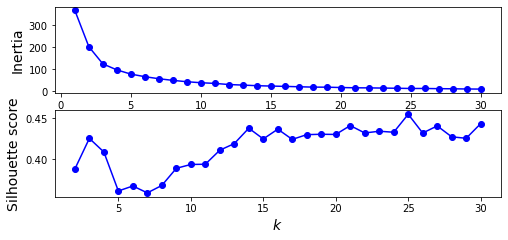

In [1004]:
from tqdm.notebook import tqdm
kmean_test_n_clusters(reduced_embedding, 30)

In [ ]:
# train this model only after the first merging step to save both memory and time
words_to_cluster =  ["accept" ,        "ally"     ,      "army"     ,      "attack"     ,    "attacking"  ,    "authority"   ,   "benefit"       
,"billion"    ,    "blackmail"    ,  "block"   ,       "boat"    ,       "bomb"     ,      "bombing"  ,      "border"        
,"break"       ,   "build"   ,       "burden"    ,     "camp" ,          "care"      ,     "child",          "citizen"       
,"city"       ,    "civil"    ,      "civilian" ,      "clash" ,         "closed"         ,"coast" ,         "community"     
,"conflict"  ,     "control"   ,     "creating",       "crime"  ,        "criminal"      , "cross"  ,        "crossing"      
,"dead"     ,      "death"      ,    "defend" ,        "desperate",      "dictator"     ,  "displaced",      "door"          
,"economic",       "economy"     ,   "entering"       ,"entry"     ,     "family"      ,   "fear"      ,     "fence"         
,"fight"          ,"fighting"     ,  "fire"          , "fled"       ,    "flee"       ,    "fleeing"    ,    "flood"         
, "flow"         ,  "food"         ,  "force"       ,   "forced"     ,    "foreign"  ,      "friend"     ,    "game"          
 ,"gate"        ,   "government"    , "guard"      ,    "health"      ,   "help"    ,       "helping"     ,   "history"       
, "hold"       ,    "hope"           ,"host"      ,     "hosting"      ,  "house"  ,        "human"        ,  "humanitarian"  
,"humanity"   ,    "hundred"  ,      "illegal"   ,     "illegally"      ,"influx" ,        "innocent"       ,"invade"        
, "invader"  ,      "invading" ,      "invasion",       "islamic"        ,"jihadist"      , "kid" ,           "kill"          
,"killed"   ,      "killing"    ,    "leaving" ,       "legal"   ,       "march"         , "mass"  ,         "military"      
, "million"       , "minister"   ,    "money"         , "movement",       "national"    ,   "number",         "official"      
, "opening"      ,  "order"       ,   "peace"        ,  "picture"  ,      "police"     ,    "policy" ,        "population"    
, "power"       ,   "pressure"     ,  "prevent"     ,   "protect"   ,     "protection",     "pushing" ,       "refuge"        
,"regime"      ,   "region"         ,"respect"     ,   "responsibility", "return"    ,     "risk"      ,     "rule"          
,"safety"     ,    "school"    ,     "security"   ,    "shelter" ,       "shooting" ,      "shot"       ,    "social"        
,"soldier"      ,  "solidarity" ,    "solution"  ,     "suffering",      "support" ,       "supporting"  ,   "tension"       
, "territory"  ,    "terrorist"  ,    "thousand",       "threat"   ,      "travel",         "troop"       ,   "violence"      
, "war"       ,     "wave"        ,   "weapon" ,        "woman"     ,     "work" ,          "worker"       ,  "working"       
, "zone"]

print(unique_tweets_df['text_alphanum'].shape)
len(words_to_cluster)